# Extracting lane change data

To extract lanewise trajectories, to be learned to extract the basis

## Preambles

Loading and previewing some data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys 
sys.path.append('/Users/thinhhoang/Documents/anomaly-detection-ngsim/')

In [3]:
df = pd.read_csv('../kalmaned2.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,...,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy,Vehicle_EKF_Accel,Vehicle_EKF_Theta,Vehicle_EKF_Velocity
0,0,0,1,270,569,1118847869000,51.164,112.878,6451136.708,1873294.084,...,19.89,0.00,5,0,0,0.0,0.0,0.352090,-0.000532,18.144384
1,1,1,1,271,569,1118847869100,51.153,114.878,6451138.053,1873292.603,...,19.89,0.00,5,0,0,0.0,0.0,0.606310,-0.000481,18.179593
2,2,2,1,272,569,1118847869200,51.143,116.878,6451139.397,1873291.122,...,19.89,0.00,5,0,0,0.0,0.0,0.662968,0.000942,18.265646
3,3,3,1,273,569,1118847869300,51.244,118.815,6451140.617,1873289.614,...,19.89,0.00,5,0,0,0.0,0.0,0.299653,0.001631,18.312187
4,4,4,1,274,569,1118847869400,51.234,120.814,6451141.961,1873288.133,...,19.89,1.07,5,0,0,0.0,0.0,0.289715,0.000712,18.325577


## Determining the road patch boundaries 

By plotting the histogram and the max, min of the vehicle coordinates

In [4]:
df['Local_X'].min()

0.879

In [5]:
df['Local_X'].max()

73.318

<AxesSubplot:>

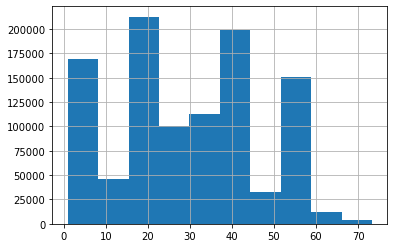

In [6]:
df['Local_X'].hist()

We see that the X of vehicles range from 0 to approximately 75ft.

<AxesSubplot:>

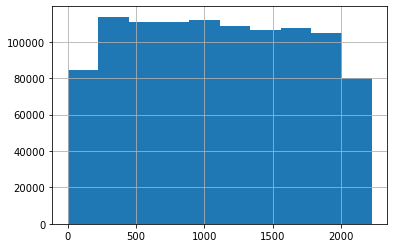

In [7]:
df['Local_Y'].hist()

In [8]:
df['Local_Y'].min()

0.0

In [9]:
df['Local_Y'].max()

2224.58

Similarly, for the Y coordinates, ranging from 0 to 2224.58ft.

## Generate a bunch of random trajectories inside the road patch

In [10]:
import pandas as pd
from ngsim_processor import NGSIM_Processor as NGSIM

if __name__ == '__main__':
    container_t = []
    container_x = []
    container_y = []
    num_of_trajs = 200
    traj_length = []

    df = pd.read_csv('../kalmaned2.csv')
    ngsim = NGSIM(df)
    ngsim.set_patch(0.0, 75.0, 500.0, 750.0) # see the notebook df_stats.py to see where these numbers come from

    for i in range(num_of_trajs):
        t, x, y = ngsim.get_trajectory_random_in_patch_for_a_duration(40000) # 40 seconds, note that the boundary is not very important
        container_t.append(t)
        container_x.append(x)
        container_y.append(y)
        traj_length.append(len(t))
        if i%50 == 0:
            print('Trajectory {:d} generated, length {:d}'.format(i, len(t)))

    print('Process completed')


# See PyCharm help at https://www.jetbrains.com/help/pycharm/

NGSIM Processor is initialized
The vehicle 232.0 disappeared before completing the trj of duration 40000
Trajectory 0 generated, length 373
The vehicle 304.0 disappeared before completing the trj of duration 40000
The vehicle 429.0 disappeared before completing the trj of duration 40000
The vehicle 940.0 disappeared before completing the trj of duration 40000
The vehicle 123.0 disappeared before completing the trj of duration 40000
The vehicle 262.0 disappeared before completing the trj of duration 40000
The vehicle 906.0 disappeared before completing the trj of duration 40000
The vehicle 21.0 disappeared before completing the trj of duration 40000
The vehicle 172.0 disappeared before completing the trj of duration 40000
The vehicle 220.0 disappeared before completing the trj of duration 40000
The vehicle 936.0 disappeared before completing the trj of duration 40000
The vehicle 1217.0 disappeared before completing the trj of duration 40000
Trajectory 50 generated, length 401
The vehicl

This is the distribution of the starting time of the trajectory (so that it can be useful to set the starting gtime of the simulator)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 151.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-1.11884784e+12, -1.11884784e+12, -1.11884784e+12, -1.11884784e+12,
        -1.11884784e+12, -1.11884784e+12, -1.11884784e+12, -1.11884784e+12,
        -1.11884784e+12, -1.11884784e+12, -1.11884784e+12, -1.11884784e+12,
        -1.11884784e+12, -1.11884784e+12, -1.11884784e+12, -1.11884784e+12,
        -1.11884784e+12, -1.11884784e+12, -1.11884784e+12, -1.11884784e+12,
        -1.11884784e+12]),
 <BarContainer object of 20 artists>)

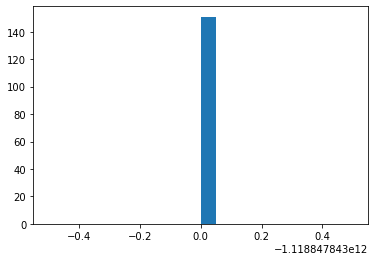

In [17]:
plt.hist(np.array([x[0] - df['Global_Time'].min() for x in container_t]), bins = 20)

Set all entrance time to zero

In [18]:
for i in range(num_of_trajs):
    container_t[i] -= container_t[i][0]
    # container_t[i] -= df['Global_Time'].min()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   3.,   0.,   0.,   3.,   1.,   0.,   2.,   3.,   4.,
          4.,   1.,   2.,   1.,   6.,   1.,   6.,   3., 155.]),
 array([168.        , 171.10666667, 174.21333333, 177.32      ,
        180.42666667, 183.53333333, 186.64      , 189.74666667,
        192.85333333, 195.96      , 199.06666667, 202.17333333,
        205.28      , 208.38666667, 211.49333333, 214.6       ,
        217.70666667, 220.81333333, 223.92      , 227.02666667,
        230.13333333, 233.24      , 236.34666667, 239.45333333,
        242.56      , 245.66666667, 248.77333333, 251.88      ,
        254.98666667, 258.09333333, 261.2   

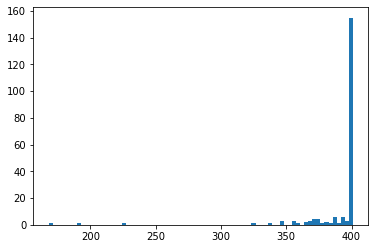

In [19]:
plt.hist(traj_length, bins=75)

From this distribution of trajectory length, we need to remove all trajectories whose length is different than 251. Here we choose copying method to new arrays because popping elements will cause the index to jump around.

In [20]:
container_t1 = []
container_x1 = []
container_y1 = []
for i in range(num_of_trajs):
    if traj_length[i]==401:
        container_t1.append(container_t[i])
        container_x1.append(container_x[i])
        container_y1.append(container_y[i])
num_of_trajs = len(container_t1)
container_x = np.array(container_x1.copy())
container_y = np.array(container_y1.copy())
container_t = np.array(container_t1.copy())
del container_t1, container_x1, container_y1

Converting to numpy arrays

In [21]:
container_x_new = np.array(container_x)
container_y_new = np.array(container_y)
container_t_new = np.array(container_t)

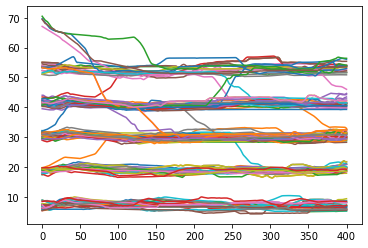

In [22]:
for i in range(num_of_trajs):
    plt.plot(container_x_new[i,:])

## Save these trajectories into a file

In [23]:
import pickle

file_to_store = open("lane.pyo", "wb")
object_to_store = {
    't_vec': container_t_new,
    'x_vec': container_x_new,
    'y_vec': container_y_new
}

pickle.dump(object_to_store, file_to_store)
file_to_store.close()

# FPCA decomposition and distribution learning

In [ ]:
import sklearn
import skfda

In [ ]:
fdgrx = skfda.FDataGrid(container_x_new, new_t_vec)
fdgry = skfda.FDataGrid(container_y_new, new_t_vec)

## FPCA decomposition for X component

In [ ]:
fdgrx.plot()
print('')
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')

In [ ]:
from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA

In [ ]:
fpca_discretized_rw = FPCA(n_components=2)
fpca_discretized_rw.fit(fdgrx)
fpca_discretized_rw.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component'])
print('')

In [ ]:
fpca_discretized_rw.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_curve = fpca_discretized_rw.mean_.data_matrix.reshape((-1))

In [ ]:
fpca_discretized_rw.explained_variance_ratio_

In [ ]:
friendly_basis_rw = fpca_discretized_rw.components_.data_matrix.squeeze().transpose()
coeffs_rw = np.matmul(container_x_new - mean_curve, friendly_basis_rw)
plt.scatter(coeffs_rw[:,0], coeffs_rw[:,1])
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

## FPCA with Y component

In [ ]:
fpca_discretized_rw2 = FPCA(n_components=2)
fpca_discretized_rw2.fit(fdgry)
fpca_discretized_rw2.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Lanewise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component'])
print('')

In [ ]:
fpca_discretized_rw2.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Lanewise coordinate (m)')
plt.grid(True)
print('')
mean_curve2 = fpca_discretized_rw2.mean_.data_matrix.reshape((-1))

In [ ]:
fpca_discretized_rw2.explained_variance_ratio_

In [ ]:
friendly_basis_rw2 = fpca_discretized_rw2.components_.data_matrix.squeeze().transpose()
coeffs_rw2 = np.matmul(container_y_new - mean_curve2, friendly_basis_rw2)
plt.scatter(coeffs_rw2[:,0], coeffs_rw2[:,1])
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

## Fitting a distribution onto the data

In [ ]:
# Plotting helper function

import itertools
from scipy import linalg
import matplotlib as mpl
def plot_results(X, Y_, means, covariances, index, title):
    color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(X[:,0].min(), X[:,0].max())
    plt.ylim(X[:,1].min(), X[:,1].max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

In [ ]:
from sklearn.mixture import GaussianMixture

Learning the X functionals (lanewise coordinate) distribution

In [ ]:
gm_rw = GaussianMixture(n_components=1, random_state=0).fit(coeffs_rw)

In [ ]:
plot_results(coeffs_rw, gm_rw.predict(coeffs_rw), gm_rw.means_, gm_rw.covariances_, 0, 'Gaussian Mixture for Lanewise PCA components')
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

Learning the Y functionals (roadwise coordinate) distribution

In [ ]:
gm_rw2 = GaussianMixture(n_components=1, random_state=0).fit(coeffs_rw2)

In [ ]:
plot_results(coeffs_rw2, gm_rw2.predict(coeffs_rw), gm_rw2.means_, gm_rw2.covariances_, 0, 'Gaussian Mixture for Roadwise PCA components')
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

## Learned parameters

For the X component

In [ ]:
gm_rw.means_

In [ ]:
gm_rw.covariances_

For the Y component

In [ ]:
gm_rw2.means_

In [ ]:
gm_rw2.covariances_

Export these gaussian mixture model to a file so that we can load it to our NGSIM simulator

In [ ]:
import pickle as pkl

pickle.dump({
    'cov': gm_rw2.covariances_,
    'mu': gm_rw2.means_,
    'mean_curve': mean_curve2,
    'friendly_basis': friendly_basis_rw2
}, open( "y.pkl", "wb" ) )

print('Y component Gaussian Mixture dumped to y.pkl')

pickle.dump({
    'cov': gm_rw.covariances_,
    'mu': gm_rw.means_,
    'mean_curve': mean_curve,
    'friendly_basis': friendly_basis_rw
}, open( "x.pkl", "wb" ) )

print('X component Gaussian Mixture dumped to x.pkl')

## Generation of Entropy Curves

In [ ]:
curve